# Computational Social Science Project #3 

Julian Vargo

*Semester:* Fall 2025

## 1. Introduction

### Load data 

In [1]:
!pip install xgboost

  Using cached xgboost-3.1.2-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.28.9-py3-none-manylinux_2_18_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-3.1.2-py3-none-manylinux_2_28_x86_64.whl (115.9 MB)
Using cached nvidia_nccl_cu12-2.28.9-py3-none-manylinux_2_18_x86_64.whl (296.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]


In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn import tree
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    VotingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    classification_report,
)

import xgboost as xgb


In [3]:
#
# read in "Inspections Data 2011-2013" csv data
# -----------
chicago_inspections_2011_to_2013 = pd.read_csv("data/Chicago Inspections 2011-2013.csv", 
                                              low_memory=False)

In [4]:
#
# read in  "Inspections Data 2014_updated" csv data
# -----------
chicago_inspections_2014 = pd.read_csv("data/Chicago Inspections 2014_updated.csv",  # be sure to use the "updated" data here
                                      low_memory=False)

In [5]:
# look at the inspections data
chicago_inspections_2011_to_2013.head()

,Inspection_ID,Inspection_Date,DBA_Name,AKA_Name,License,Facility_Type,Risk,Address,City,State,Zip,Inspection_Type,Results,Latitude,Longitude,Location,Facility_Type_Clean,criticalCount,seriousCount,minorCount,pass_flag,fail_flag,pastFail,pastCritical,pastSerious,pastMinor,timeSinceLast,firstRecord,ID,LICENSE_ID,ACCOUNT_NUMBER,LEGAL_NAME,DOING_BUSINESS_AS_NAME,ADDRESS,CITY,STATE,ZIP_CODE,WARD,PRECINCT,WARD_PRECINCT,POLICE_DISTRICT,LICENSE_CODE,LICENSE_DESCRIPTION,BUSINESS_ACTIVITY_ID,BUSINESS_ACTIVITY,LICENSE_NUMBER,APPLICATION_TYPE,LICENSE_TERM_START_DATE,LICENSE_TERM_EXPIRATION_DATE,LICENSE_STATUS,LATITUDE,LONGITUDE,minDate,maxDate,ageAtInspection,consumption_on_premises_incidental_activity,tobacco,package_goods,outdoor_patio,public_place_of_amusement,limited_business_license,childrens_services_facility_license,tavern,regulated_business_license,filling_station,caterers_liquor_license,mobile_food_license,precipIntensity,temperatureMax,windSpeed,humidity,heat_burglary,heat_garbage,heat_sanitation,criticalFound
0,269961,2013-01-31,SEVEN STAR,SEVEN STAR,30790,Grocery Store,Risk 3 (Low),3352 N BROADWAY,CHICAGO,IL,60657.0,Canvass,Pass,41.943359,-87.644999,"(41.943359344775146, -87.64499875300952)",Other,0,0,2,1,0,0,0,0,0,2.0,1,30790-20110416,2081412.0,63759.0,VIRGINIA DELA ROSA,SEVEN STAR,3352 N BROADWAY 1,CHICAGO,IL,60657.0,44.0,33.0,44-33,19.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,30790.0,RENEW,2011-04-16,2013-04-15,AAI,41.943359,-87.644999,2002-02-16,2015-04-15,10.964384,0,1,0,0,0,1,0,0,0,0,0,0,0.014587,53.496667,13.340000,0.900000,26.992376,12.768572,37.748787,0
1,507211,2011-10-18,PANERA BREAD,PANERA BREAD,1475890,Restaurant,Risk 1 (High),6059 N LINCOLN AVE,CHICAGO,IL,60659.0,Canvass,Pass,41.991919,-87.709631,"(41.99191947239194, -87.70963133440333)",Restaurant,0,0,3,1,0,0,0,0,0,2.0,1,1475890-20110416,2081695.0,207283.0,"PANERA, LLC",PANERA BREAD,6059 N LINCOLN AVE C,CHICAGO,IL,60659.0,50.0,23.0,50-23,24.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1475890.0,RENEW,2011-04-16,2013-04-15,AAI,41.991919,-87.709631,2004-05-05,2019-04-15,7.457534,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,13.976557,12.895485,15.412267,0
2,507212,2011-10-18,LITTLE QUIAPO RESTAURANT,LITTLE QUIAPO RESTAURANT,1740130,Restaurant,Risk 1 (High),6259 N MCCORMICK RD,CHICAGO,IL,60659.0,Canvass,Fail,41.995632,-87.712707,"(41.99563177556418, -87.71270678169132)",Restaurant,0,2,6,0,1,0,0,0,0,2.0,1,1740130-20110216,2070145.0,3107.0,ENELITA GARCIA,LITTLE QUIAPO RESTAURANT,6259 N MCCORMICK RD,CHICAGO,IL,60659.0,50.0,25.0,50-25,17.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1740130.0,RENEW,2011-02-16,2013-02-15,AAI,41.995632,-87.712707,2007-03-22,2017-02-15,4.578082,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,12.611239,8.004220,8.320330,0
3,507216,2011-10-19,SERGIO'S TAQUERIA PIZZA INC.,SERGIO'S TAQUERIA PIZZA,1447363,Restaurant,Risk 1 (High),3253 W BRYN MAWR AVE,CHICAGO,IL,60659.0,Canvass,Pass,41.982933,-87.710982,"(41.982933189164974, -87.71098225381141)",Restaurant,0,0,6,1,0,0,0,0,0,2.0,1,1447363-20110216,2071895.0,270993.0,SERGIO'S TAZUERIA PIZZA INC.,SERGIO'S TAQUERIA PIZZA INC.,3253 W BRYN MAWR AVE,CHICAGO,IL,60659.0,39.0,48.0,39-48,17.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1447363.0,RENEW,2011-02-16,2013-02-15,AAI,41.982933,-87.710982,2003-12-31,2019-02-15,7.805479,0,0,0,0,0,0,0,0,0,0,0,0,0.002737,56.153333,10.863333,0.616667,35.906383,26.238645,38.186618,0
4,507219,2011-10-20,TARGET STORE # T-2079,TARGET,1679459,Restaurant,Risk 2 (Medium),2112 W PETERSON AVE,CHICAGO,IL,60659.0,Canvass,Fail,41.990729,-87.682979,"(41.99072921796059, -87.68297945359863)",Restaurant,0,2,6,0,1,0,0,0,0,2.0,1,1679459-20100216,2009972.0,15538.0,TARGET CORPORATION,TARGET STORE # T-2079,2112 W PETERSON AVE,CHICAGO,IL,60659.0,40.0,18.0,40-18,24.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1679459.0,RENEW,

In [6]:
# list column names
chicago_inspections_2011_to_2013.columns

Index(['Inspection_ID', 'Inspection_Date', 'DBA_Name', 'AKA_Name', 'License',
       'Facility_Type', 'Risk', 'Address', 'City', 'State', 'Zip',
       'Inspection_Type', 'Results', 'Latitude', 'Longitude', 'Location',
       'Facility_Type_Clean', 'criticalCount', 'seriousCount', 'minorCount',
       'pass_flag', 'fail_flag', 'pastFail', 'pastCritical', 'pastSerious',
       'pastMinor', 'timeSinceLast', 'firstRecord', 'ID', 'LICENSE_ID',
       'ACCOUNT_NUMBER', 'LEGAL_NAME', 'DOING_BUSINESS_AS_NAME', 'ADDRESS',
       'CITY', 'STATE', 'ZIP_CODE', 'WARD', 'PRECINCT', 'WARD_PRECINCT',
       'POLICE_DISTRICT', 'LICENSE_CODE', 'LICENSE_DESCRIPTION',
       'BUSINESS_ACTIVITY_ID', 'BUSINESS_ACTIVITY', 'LICENSE_NUMBER',
       'APPLICATION_TYPE', 'LICENSE_TERM_START_DATE',
       'LICENSE_TERM_EXPIRATION_DATE', 'LICENSE_STATUS', 'LATITUDE',
       'LONGITUDE', 'minDate', 'maxDate', 'ageAtInspection',
       'consumption_on_premises_incidental_activity', 'tobacco',
       'package_goods',

In [7]:
# drop column names related to geography, identification, and pass/fail flags that perfectly predict the outcome
chicago_inspections_2011_to_2013.drop(columns=['AKA_Name','License','Address','City','State','Zip','Latitude','Longitude','Location','ID','LICENSE_ID','LICENSE_TERM_START_DATE','LICENSE_TERM_EXPIRATION_DATE','LICENSE_STATUS','ACCOUNT_NUMBER','LEGAL_NAME','DOING_BUSINESS_AS_NAME','ADDRESS','CITY','STATE','ZIP_CODE','WARD','PRECINCT','LICENSE_CODE','BUSINESS_ACTIVITY_ID','BUSINESS_ACTIVITY','LICENSE_NUMBER','LATITUDE','LONGITUDE','pass_flag','fail_flag'],inplace=True)

# set index
chicago_inspections_2011_to_2013.set_index(['Inspection_ID', 'DBA_Name'], inplace = True)

# convert the inspection date to a datetime format
chicago_inspections_2011_to_2013['Inspection_Date'] = pd.to_datetime(chicago_inspections_2011_to_2013['Inspection_Date'])  

### Visualization

Let's visualize what inspections look like over time.

<Axes: title={'center': 'Inspections by Month and Year'}, xlabel='Inspection_MonthYear'>

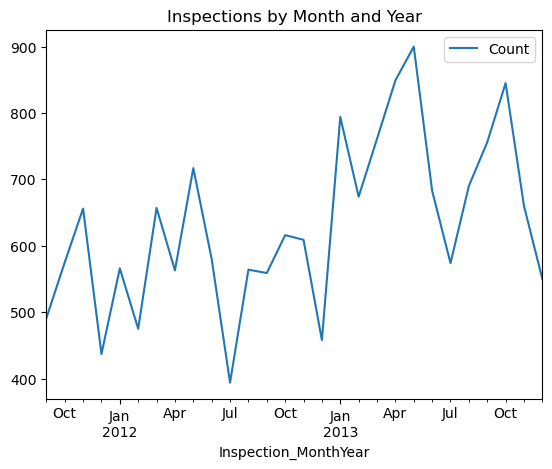

In [8]:
# visualize inspections over time
# -----------
chicago_inspections_2011_to_2013['Inspection_MonthYear'] = chicago_inspections_2011_to_2013['Inspection_Date'].dt.to_period('M')
counts_by_day = chicago_inspections_2011_to_2013.groupby('Inspection_MonthYear').count().rename(columns = {'Facility_Type': 'Count'})['Count'].reset_index()
counts_by_day.set_index(["Inspection_MonthYear"], inplace = True)
counts_by_day.plot(title = "Inspections by Month and Year") 

Let's visualize what the distribution of results looks like.

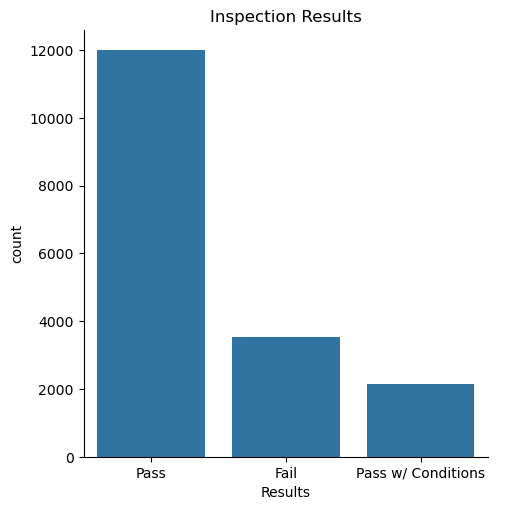

In [9]:
# view inspection results
# -----------
sns.catplot(data = chicago_inspections_2011_to_2013,
           x = "Results",
           kind = "count")

plt.title("Inspection Results")
plt.show()

What if we separate results by facility type?

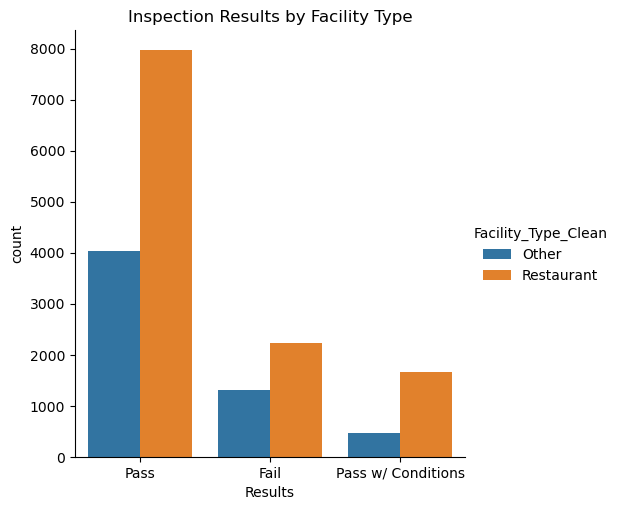

In [10]:
# view inspection results by facility type (restaurant or not)
# -----------
sns.catplot(data = chicago_inspections_2011_to_2013,
            x = "Results",
            kind = "count",
            hue = 'Facility_Type_Clean')

plt.title("Inspection Results by Facility Type")
plt.show();

## 2. Data Preprocessing and Cleaning

In [11]:
# drop datetime info
chicago_inspections_2011_to_2013 = chicago_inspections_2011_to_2013.dropna().drop(['Inspection_Date','minDate','maxDate','Inspection_MonthYear'],axis = 1)

In [12]:
# process target 
# -----------
y = chicago_inspections_2011_to_2013['Results']

# decide if you want to binarize the outcome variable 
# comment out the following lines of code if you don't want to binarize the target variable
y = y.replace({'Pass w/ Conditions': 'Pass'})
lb_style = LabelBinarizer()
y = lb_style.fit_transform(y)

# recode 0s and 1s so 1s are "Fail"
y = np.where(y == 1, 0 ,1)

# process features

# create feature dataset
X = chicago_inspections_2011_to_2013.drop(columns = ['Results', 'Facility_Type', 'LICENSE_DESCRIPTION', 'WARD_PRECINCT'])

# get dummies
X = pd.get_dummies(X)

In [13]:
# view feature datset
X.head()

,,criticalCount,seriousCount,minorCount,pastFail,pastCritical,pastSerious,pastMinor,timeSinceLast,firstRecord,POLICE_DISTRICT,ageAtInspection,consumption_on_premises_incidental_activity,tobacco,package_goods,outdoor_patio,public_place_of_amusement,limited_business_license,childrens_services_facility_license,tavern,regulated_business_license,filling_station,caterers_liquor_license,mobile_food_license,precipIntensity,temperatureMax,windSpeed,humidity,heat_burglary,heat_garbage,heat_sanitation,criticalFound,Risk_Risk 1 (High),Risk_Risk 2 (Medium),Risk_Risk 3 (Low),Inspection_Type_Canvass,Facility_Type_Clean_Other,Facility_Type_Clean_Restaurant,APPLICATION_TYPE_C_EXPA,APPLICATION_TYPE_C_LOC,APPLICATION_TYPE_ISSUE,APPLICATION_TYPE_RENEW
Inspection_ID,DBA_Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
269961,SEVEN STAR,0,0,2,0,0,0,0,2.0,1,19.0,10.964384,0,1,0,0,0,1,0,0,0,0,0,0,0.014587,53.496667,13.340000,0.900000,26.992376,12.768572,37.748787,0,False,False,True,True,True,False,False,False,False,True
507211,PANERA BREAD,0,0,3,0,0,0,0,2.0,1,24.0,7.457534,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,13.976557,12.895485,15.412267,0,True,False,False,True,False,True,False,False,False,True
507212,LITTLE QUIAPO RESTAURANT,0,2,6,0,0,0,0,2.0,1,17.0,4.578082,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,12.611239,8.004220,8.320330,0,True,False,False,True,False,True,False,False,False,True
507216,SERGIO'S TAQUERIA PIZZA INC.,0,0,6,0,0,0,0,2.0,1,17.0,7.805479,0,0,0,0,0,0,0,0,0,0,0,0,0.002737,56.153333,10.863333,0.616667,35.906383,26.238645,38.186618,0,True,False,False,True,False,True,False,False,False,True
507219,TARGET STORE # T-2079,0,2,6,0,0,0,0,2.0,1,24.0,5.290411,0,0,1,0,0,1,0,0,0,0,0,0,0.009987,52.730000,16.266667,0.690000,9.530785,3.401567,2.126788,0,False,True,False,True,False,True,False,False,False,True


In [14]:
# Set seed
np.random.seed(1)

# training and test split 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20,
                                                    stratify=y)

# training and validation split 
X_train, X_validate, y_train, y_validate = train_test_split(X_train, 
                                                            y_train, 
                                                            train_size = .75, 
                                                            test_size = .25, 
                                                            stratify = y_train)

## 3. Fit Models

Now choose 3 different machine learning techniques and apply them below. Choose from one of the algorithms we have used in lab (e.g., logistic regression, random forests, `AdaBoost()`, `xgboost()`, `VotingClassifer()`, or `BART`). 

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem. Also, be sure to do the following:

1. Import the appropriate library from sklearn
2. Set up a hyperparameter grid (check out our previous labs to see how to do this)
3. Find the best hyperparameters, and then fit your model (using either train/validation splits or cross-validation)

### Model 1 - Random Forest

In [15]:
randomforestanswer = """
For Random Forest, this model would be good for the present problem because
it is able to binarily classify whether an establishment is likely to pass
or fail an inspection. One benefit of using this model is that each decision
tree is generated based on a random subset of the data and a random subset
of variables. This means that the model won't overly rely on a single particular
variable to make predictions. A drawback for random forests is that
it has to generate a bunch of separate trees to create an average across the trees,
not necessarily improving accuracy at every iteration.

"""

In [16]:
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf_classifier = RandomForestClassifier(
                       # specify parameters
                       n_estimators=100,              # specify the number of trees (100 is default)
                       criterion='gini',              # or you can use 'entropy' for information gain
                       max_depth=None,                # how deep tree nodes can go
                       min_samples_split=2,           # samples needed to split node
                       min_samples_leaf=1,            # samples needed for a leaf
                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                       max_features=None,             # number of features to look for when splitting
                       max_leaf_nodes=None,           # max nodes
                       min_impurity_decrease=1e-07,   # early stopping
                       random_state = 10)             # random seed

grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=rf_param_grid,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)

best_rf = grid_search.best_estimator_

y_pred_grid = best_rf.predict(X_test)

print(classification_report(y_test, y_pred_grid))

/srv/conda/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/srv/conda/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/srv/conda/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/srv/conda/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Estimator: RandomForestClassifier(max_depth=10, max_features=None,
                       min_impurity_decrease=1e-07, min_samples_leaf=2,
                       min_samples_split=5, random_state=10)
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      2445
           1       0.77      0.93      0.84       618

    accuracy                           0.93      3063
   macro avg       0.88      0.93      0.90      3063
weighted avg       0.94      0.93      0.93      3063



###  Model 2 - xgboost

In [17]:
xgboostanswer = """
For xgboost, this model would be good for the present problem because
it is able to binarily classify whether an establishment is likely to pass
or fail an inspection, just like the Random Forest. One benefit of using this model is that this algorithm randomly
tweaks the tree from the previous iteration and continuously improves the model without making an average tree.
This algorithm is a lot faster than Random Forest, without sacrificing accuracy.
A drawback for xgboost is that it's not as easy to interpret as a logistic regression, and if a restaurant gets flagged,
we don't know the specific reasons for that restaurant being flagged.

"""

xgb_model = xgb.XGBClassifier(
    random_state=10
)

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    cv=5,
    n_jobs=-1
)

xgb_grid_search.fit(X_train, y_train)

print("Best XGBoost parameters:", xgb_grid_search.best_params_)
best_xgb = xgb_grid_search.best_estimator_

y_pred_xgb = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))


Best XGBoost parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      2445
           1       0.78      0.88      0.83       618

    accuracy                           0.93      3063
   macro avg       0.88      0.91      0.89      3063
weighted avg       0.93      0.93      0.93      3063



### Model 3 - logistic Regression

In [18]:
logreganswer = """
Logistic regressions are good for the present problem because
it is able to binarily classify whether an establishment is likely to pass
or fail an inspection, just like the Random Forest or XGBoost. One benefit of using this model is that it performs fairly fast and
the results are easily interpretable coefficients based on the column names present in the original variable.
A downside to using logistic regression is that it doesn't grow trees or add random noise or random subsetting into the data
like the ensemble method to reduce overfitting and maximize explanatory power.
"""

log_reg = LogisticRegression(
    max_iter=1000,
    random_state=10
)

log_reg_param_grid = {
    'C': np.arange(0.1, 1.0, 0.1),
    'fit_intercept': [True, False],
    'solver': ['liblinear'],
    'penalty': ['l2']
}

logit_grid = GridSearchCV(
    estimator=log_reg,
    param_grid=log_reg_param_grid,
    cv=3,
    n_jobs=-1
)

logit_grid.fit(X_train, y_train.ravel())

best_log_reg = logit_grid.best_estimator_
y_pred = best_log_reg.predict(X_validate)

print("Best params:", logit_grid.best_params_)
print('Validation Accuracy',  accuracy_score(y_validate, y_pred))
print('Validation Recall',    recall_score(y_validate, y_pred))
print('Validation Precision', precision_score(y_validate, y_pred))
print('Validation F1',        f1_score(y_validate, y_pred))


Best params: {'C': np.float64(0.8), 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
Validation Accuracy 0.9150881776616591
Validation Recall 0.8541329011345219
Validation Precision 0.7560975609756098
Validation F1 0.802130898021309


### Validation Metrics

Be sure to explain which of these metrics you would want to prioritize when conducting predictive auditing in this context and why.

**Hint**: Try writing a for loop to use [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) to check for accuracy, precision, recall and f1 across all of your models.

In [19]:
answer ="""Recall is the most important metric because 
I want to ensure that I am correctly capturing all of the restaurants that fail the inspection.
If recall represents fails_detected / total_number_number_of_actual_fails,
then I know whether a model minimized the number of business that flew under the radar."""

models = {
    'log_reg': best_log_reg,
    'random_forest': best_rf,
    'xgboost': best_xgb
}

scorers = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

for name, model in models.items():
    print(f"Model: {name}")
    for metric_name, scorer in scorers.items():
        scores = cross_val_score(model, X, y.ravel(), cv=5, scoring=scorer)
        print(f"{metric_name}: {scores.mean():.3f}")

Model: log_reg
accuracy: 0.921
precision: 0.783
recall: 0.843
f1: 0.811
Model: random_forest
accuracy: 0.925
precision: 0.766
recall: 0.904
f1: 0.829
Model: xgboost
accuracy: 0.925
precision: 0.782
recall: 0.870
f1: 0.823


## 4. Policy Simulation

### Interpretable Machine Learning

Use tools like coefficient plots or feature importance plots to investigate your models. Which features contribute to your predictions? Are there any additional features you wish you could incorporate that you don't have available in this analysis?

**Hint**: Use tools like feature importance plots and coefficient plots.

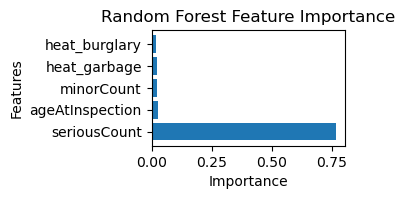

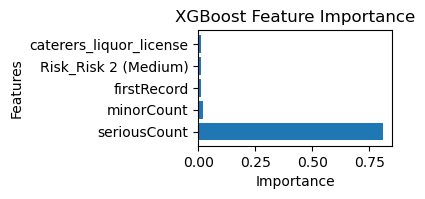

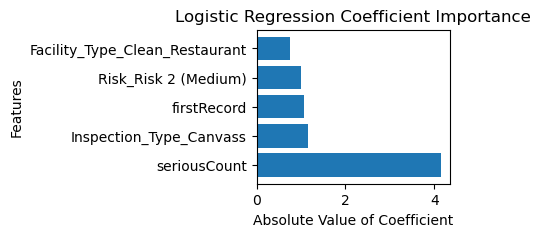

In [34]:
importances = best_rf.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})
feature_importance = (
    feature_importance
    .sort_values('importance', ascending=False)
    .head(5)
)
plt.figure(figsize=(2.5, 1.5))
plt.barh(
    feature_importance['feature'],
    feature_importance['importance'],
    align='center'
)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()

importances = best_xgb.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})
feature_importance = (
    feature_importance
    .sort_values('importance', ascending=False)
    .head(5)
)
plt.figure(figsize=(2.5, 1.5))
plt.barh(
    feature_importance['feature'],
    feature_importance['importance'],
    align='center'
)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.show()

coefs = best_log_reg.coef_.ravel()

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefs,
})
feature_importance['abs_coef'] = feature_importance['Coefficient'].abs()
top5 = feature_importance.nlargest(5, 'abs_coef')

plt.figure(figsize=(2.5, 2))
plt.barh(top5['Feature'], top5['abs_coef'], align='center')
plt.xlabel('Absolute Value of Coefficient')
plt.ylabel('Features')
plt.title('Logistic Regression Coefficient Importance')
plt.show()

In [21]:
answer = """
It appears that the number of seriousCounts that a business has
is the overwhelmingly important predictor for telling
whether a business will fail a health inspection.

I wish we had information about what caused each business's
serious count, because a more granular seriousCount variable
might be able to give us better predictions in our model.

"""

### Prioritize Audits

**Hint**: Look up the [`.predict()`](https://www.kite.com/python/docs/sklearn.linear_model.SGDRegressor.predict), [`.predict_proba()`](https://www.kite.com/python/docs/sklearn.linear_model.LogisticRegression.predict_proba), and [`.sample()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) methods. Then: 
1. Choose one of your models (or train a new simplified model or ensemble!) to predict outcomes and probabilities. 
2. Order your audits by their probability of detecting a "Fail" score
3. Plot your distribution of pass/fail among the first 1,000 observations in the dataset
4. Simulate random audits on the full chicago_2011_to_2013.csv dataset by picking 1,000 observations at random

In [22]:
#
# 1. Choose one of your models (or train a new simplified model or ensemble!) to predict outcomes and probabilities.
# -----------
# I will be using a random forest
probs = best_rf.predict_proba(X)   # shape: (n_rows, 2)

# Turn into a DataFrame and attach to the original data
p = pd.DataFrame(
    probs,
    index=chicago_inspections_2011_to_2013.index,
    columns=['prob_pass', 'prob_fail']
)

# Add the actual result (simplified)
p['Results'] = (
    chicago_inspections_2011_to_2013['Results']
    .replace({'Pass w/ Conditions': 'Pass'})
)

p.head()

,,prob_pass,prob_fail,Results
Inspection_ID,DBA_Name,,,
269961,SEVEN STAR,1.000000,0.000000,Pass
507211,PANERA BREAD,1.000000,0.000000,Pass
507212,LITTLE QUIAPO RESTAURANT,0.061656,0.938344,Fail
507216,SERGIO'S TAQUERIA PIZZA INC.,1.000000,0.000000,Pass
507219,TARGET STORE # T-2079,0.385556,0.614444,Fail


In [23]:
# 2. Order your audits by their probability of detecting a "Fail" score
# -----------
sorted_table = p.sort_values('prob_fail', ascending=False)

# First 1,000 = the ones you would choose to audit
top_1000 = sorted_table.head(1000)

top_1000.head()

,,prob_pass,prob_fail,Results
Inspection_ID,DBA_Name,,,
1227771,SUPER FURNITURE & FOOD MART,0.001581,0.998419,Fail
920229,BURGER KING #1250,0.001736,0.998264,Fail
1353330,"PETRA MINI MART, INC.",0.001736,0.998264,Fail
606459,79 FOOD BASKET,0.001736,0.998264,Fail
545549,MARGARITA'S PIZZERIA,0.001736,0.998264,Fail


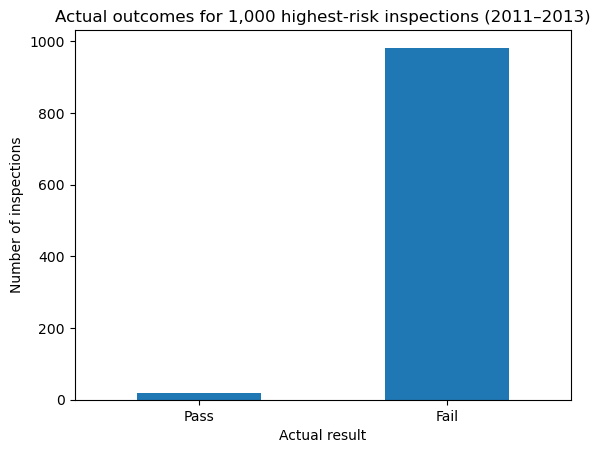

In [24]:
# 3. Plot your distribution of pass/fail among the first 1,000 observations in the dataset

top_1000_results = top_1000['Results']

plot = (
    top_1000_results
    .value_counts()
    .reindex(['Pass', 'Fail'])     # force consistent order
    .plot(kind='bar')
)

plot.set_ylabel('Number of inspections')
plot.set_xlabel('Actual result')
plot.set_title('Actual outcomes for 1,000 highest-risk inspections (2011–2013)')
plot.set_xticklabels(['Pass', 'Fail'], rotation=0)

plt.show()

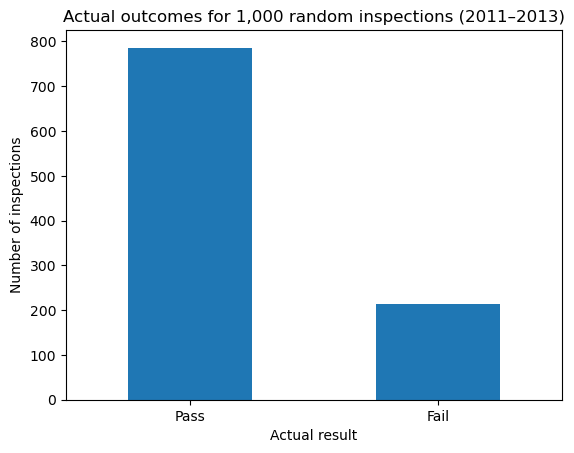

In [25]:
# 4. Simulate random audits on the full chicago_2011_to_2013.csv dataset by picking 1,000 observations at random
random_1000_results = (
    chicago_inspections_2011_to_2013['Results']
    .replace({'Pass w/ Conditions': 'Pass'})
    .sample(n=1000, random_state=1)
)

plot = (
    random_1000_results
    .value_counts()
    .reindex(['Pass', 'Fail'])
    .plot(kind='bar')
)

plot.set_ylabel('Number of inspections')
plot.set_xlabel('Actual result')
plot.set_title('Actual outcomes for 1,000 random inspections (2011–2013)')
plot.set_xticklabels(['Pass', 'Fail'], rotation=0)

plt.show()

### Predict on 2014 inspection data

# Use your favorite model to make predictions based on the features using the "Chicago Inspection 2014_updated.csv" file. Treat this as you would a test dataset. This means you will have to format the features (including removing some features and getting dummies) and the label (binarize and recode) in the same way you did the training data. (Remember the "Results" column is your label). You will then compare your predictions with the actual.

In [28]:
# ----- 2014 data processing -----
    
X_test2014 = chicago_inspections_2014.drop(
    columns=['AKA_Name','License','Address','City','State','Zip','Latitude','Longitude','Location','ID','LICENSE_ID','LICENSE_TERM_START_DATE','LICENSE_TERM_EXPIRATION_DATE','LICENSE_STATUS','ACCOUNT_NUMBER','LEGAL_NAME','DOING_BUSINESS_AS_NAME','ADDRESS','CITY','STATE','ZIP_CODE','WARD','PRECINCT','LICENSE_CODE','BUSINESS_ACTIVITY_ID','BUSINESS_ACTIVITY','LICENSE_NUMBER','LATITUDE','LONGITUDE'])

X_test2014 = pd.get_dummies(X_test2014)

X_test2014 = X_test2014.reindex(columns=X.columns, fill_value=0)

y_test2014 = chicago_inspections_2014['Results'].replace({'Pass w/ Conditions': 'Pass'})
y_test2014 = lb_style.transform(y_test2014)
y_test2014 = np.where(y_test2014 == 1, 0, 1)


In [30]:
# predict and compare 
# -----------
y_pred2014 = best_rf.predict(X_test2014)

# optional: probability that each inspection fails
y_proba2014 = best_rf.predict_proba(X_test2014)[:, 1]

# 0 = pass, 1 = fail
# confusion table that compares actual versus predicted results
pd.crosstab(
    y_test2014.ravel(),
    y_pred2014,
    rownames=['Actual'],
    colnames=['Predicted)']
)

Predicted),0,1
Actual,,
0,3412,312
1,122,777


In [31]:
# evaluate
# -----------
print(classification_report(y_test2014, y_pred2014))

print("Accuracy:",  accuracy_score(y_test2014, y_pred2014))
print("Recall:",    recall_score(y_test2014, y_pred2014))
print("Precision:", precision_score(y_test2014, y_pred2014))
print("F1:",        f1_score(y_test2014, y_pred2014))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      3724
           1       0.71      0.86      0.78       899

    accuracy                           0.91      4623
   macro avg       0.84      0.89      0.86      4623
weighted avg       0.92      0.91      0.91      4623

Accuracy: 0.9061215660826303
Recall: 0.864293659621802
Precision: 0.7134986225895317
F1: 0.7816901408450704


## 5. Discussion Questions

# 1. Why do we need metrics beyond accuracy when using machine learning in the social sciences and public policy?
##################
# We need metrics besides accuracy, because for problems such as audits, accuracy isn't the most important metric. For audits, the
# most important problem to solve is to catch everyone who is failing the inspection. Accuracy captures the overall general picture of how
# well the model performs at finding truthful values in general, but recall specifically targets how many failures we correctly predicted. If I audit a restaurant that turns out to be following the health codes, then nothing bad happens. However, if I don't accurately predict which restaurants fail,
# then people could get sick.

# We can imagine a similar need for recall metrics in cancer research. Perhaps I don't care so much about how good my model performs overall, but I want to make sure that I'm correctly predicting every single malignant tumor 100% of the time, even if that means I'm also accidentally flagging benign tumors.

# Another important metric for audits and public policy is precision, because this tells me how many failures there actually were versus how many businesses I flagged. It is possible that I correctly find every single failing business with a conservative model, but this is at the expense of precision. Being more precise means that I'm saving money, because I don't need to hire so many people or dedicate so much time towards conducting inspections, which take a lot of time. If we have low precision, then we're wasting time inspecting businesses that meet all of the health codes.

# 2. Imagine that establishments learned about the algorithm being used to determine who gets audited and they started adjusting their behavior (and changing certain key features about themselves that were important for the prediction) to avoid detection. How could policymakers address this interplay between algorithmic decisionmaking and real world behavior?
######################
# For the models that we generate in this particular homework, the number of previous serious violations is the best predictor, which means that businesses might only do the bare minimum to not get serious violations (but may still do practices that earn them minor violations). From a public policy standpoint, we can perform truly random inspections, not determined by any machine learning model, for 5% of all of the inspections. This way, there is still a random component so businesses are still inclined to follow the law. If 95% of the inspections use the model, then we still do a fairly good job at maximizing inspection efficiency but people can't entirely rely on 'beating the algorithm'.